(labs:cor3)=
# Lossy compression

<hr>

## 📌 Commentaires pour les intervenants

**Exercice sur la convolution**

* 📣 Conseillez aux étudiants de représenter les PSF, en plus du résultat de la convolution.
  Laissez-les réfléchir un peu pour savoir comment ils peuvent s'y prendre
  (sachant que pour la gaussienne, on n'utiliser pas une matrice, mais la fonction `gaussian`).
  L'idée est de convoluer un dirac (qu'il faut alors créer !).
  
* Ils peuvent également essayer d'utiliser d'autres PSF.


**Exercice sur la transformée de Fourier**

* Il est possible que le module ne soit pas visible.
  Dans ce cas, expliquer que les intensités sont écrasées (l'intensité de la fréquence nulle étant très grande).
  Une solution est d'afficher le logarithme du module (en valeur absolue) :
  c'est en fait une transformation d'histogramme, comme on a vu dans la séance précédente.
 
* Dès qu'ils affichent le résultat pour plusieurs images, discuter avec eux de ce qu'ils observent, et donc interprètent.


**Exercice sur le filtrage**

* C'est un nouvel exercice qu'on ne faisait pas les années précédentes !
  Je l'ai rajouté (en remplacement d'un précédent) pour donner un côté pratique au produit de convolution et à la transformée de Fourier
  
* Attention, comme il est question de crénelage (_aliasing_), il ne faut pas afficher les images dans le notebook avec `imshow`,
  car les images seront forcément affichées avec un zoom qu'on ne peut pas contrôler, et donc qui risque d'ajouter de l'aliasing...
  À la place, utiliser l'afficheur Linux de base après avoir enregistré les images, en veillant à avoir un zoom à 100 %.
  On peut d'ailleurs faire en sorte que cet afficheur soit toujours visible
  en cliquant sur la barre de titre de la fenêtre avec le bouton droit,
  puis en sélectionnant « Toujours au premier plan ».
  📣 Tout ceci sera à faire en point oral aux étudiants.
  
* 📣 Un autre point oral à faire : expliquer comment fonctionne le masque à appliquer sur la DCT de l'image.
  Je pense qu'un petit schéma de ce masque, en expliquant les coordonnées du carré de 1 peut être intéressant.


**Exercice sur la compression JPEG**

* Certains étudiants peuvent être étonnés que l'image associée au coefficient (0,0) soit toute noire (cf. correction).
  S'ils ne sont pas étonnés, leur faire remarquer !
  La raison est la colormap qui n'est pas identique avec les autres reconstruction : l'image ici est constante, mais pas nulle.

* L'EQM (MSE) n'a pas été vue en cours (mais la définition est dans l'énoncé).

* Si les étudiants ont fini ce TP et bien répondu à vos questions, ils peuvent terminer le TP 1.

<hr>

In [1]:
import numpy as np
import scipy as sp
import skimage as ski
import skimage.io as io
import skimage.filters as flt
import skimage.transform as tr
import matplotlib.pyplot as plt
import scipy.fftpack as fftpack

### Objectives
* know how to implement the basic principle of JPEG compression
* use the discrete cosine transform
* analyze the effect of compression on visual quality and PSNR

In [16]:
import warnings
warnings.filterwarnings("ignore")

In [17]:
# from math import pi, log10

# from numpy import zeros, log, absolute, linspace, meshgrid, count_nonzero, round
# from numpy.linalg import norm



# from skimage.io import imread
# from skimage.color import rgb2gray

# from matplotlib.pyplot import figure, imshow, show, subplot, title, plot, xlabel, ylabel #, , , show, plot, axis, axis

### Images of the DCT basis

First of all, it is interesting to view the elements of the DCT basis.

Since the images of the base correspond to a single non-zero coefficient in the domain of the transform,
a solution to display these images is to create images that are zero in the domain of the transform, except in a single pixel.
By using the function `scipy.fftpack.idctn`, we can get the corresponding 2D cosine.
The low frequencies are at the top left.

Here are some examples of images of the base (on the first line) and their DCT (on the second line) for a size of 8 × 8 pixels.

In [18]:
# Pour afficher toute la base
# i = 0
# figure(figsize=(15,15))
# for r in range(8):
#     for c in range(8):
#         i += 1
#         X = zeros((8,8))
#         X[r,c] = 1
#         x = idctn(X)
#         subplot(8,8,i)
#         imshow(x, cmap="gray")

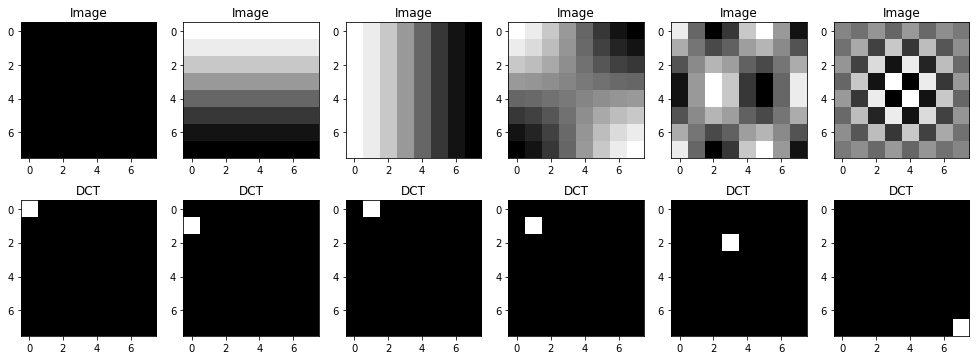

In [19]:
# Pixels (dans le domaine de la DCT) à considérer
px = ( (0,0), (1,0), (0,1), (1,1), (2,3), (7,7) )
I = len(px)

plt.figure(figsize=(17,6))

for i, p in enumerate(px):
    
    # DCT (nulle partout sauf au pixel p)
    X = np.zeros((8,8))
    X[p] = 1
    
    # DCT inverse (ne pas oublier l'option norm='ortho' !)
    x = fftpack.idctn(X, norm='ortho')
    
    # Affichage de l'image de la base
    plt.subplot(2,I,i+1)
    plt.imshow(x, cmap='gray')
    plt.title('Image')
    
    # Affichage de la DCT
    plt.subplot(2,I,i+I+1)
    plt.imshow(X, cmap='gray')
    plt.title('DCT')

It can be seen that the pixels at the top left of the DCT (therefore close to the origin) correspond to a low-frequency
since the corresponding image is a 2D cosine of low frequency in the spatial domain.
Conversely, the pixel at the bottom right is the very high frequency component:
the intensity of the pixels changes very quickly in the image.

### Application of the JPEG principle

Unlike the Fourier transform which decomposes an image as complex exponentials, the DCT decomposes an image as real cosines.
Therefore the result is not complex; there is no need to display modulus and phase.
Yet, the zero frequency coefficient being much greater than the others,
the contrast of the DCT must be modified (how?) to visualize it.

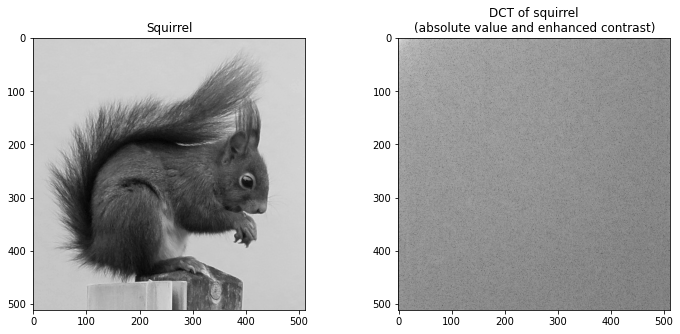

In [20]:
x = io.imread("squirrel.png")
X = fftpack.dctn(x, norm='ortho')

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(x, cmap="gray")
plt.title('Squirrel')
plt.subplot(1,2,2)
plt.imshow(np.log(np.absolute(X)), cmap='gray')
plt.title('DCT of squirrel\n(absolute value and enhanced contrast)');
plt.show()

We can notice (even if it is not obvious) that the low-frequency coefficients are more energetic than the others.
This means that the image is mostly made up of low frequencies.

To perform the compression, we choose to cancel the high-frequency pixels using a square mask of side $C$.
The size of the square divided by the image size corresponds to the compression rate.

In [21]:
# Taille (en pixels) du carré utilisé pour le masque
C = 120

# Taille de l'image originale
(M, N) = x.shape

# Taux de compression
taux = (C*C) / (M*N)

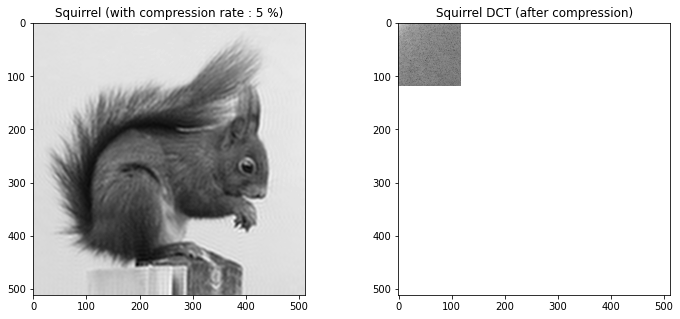

In [22]:
# Copie de la DCT
Y = X.copy()

# Masque
Mask = np.zeros(Y.shape)
Mask[:C,:C] = 1
Z = Y*Mask
z = fftpack.idctn(Z, norm='ortho')

# Affichage
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(z, cmap='gray')
plt.title('Squirrel (with compression rate : {:.0f} %)'.format(taux*100))
plt.subplot(1,2,2)
plt.imshow(np.log(np.absolute(Z)), cmap='gray')
plt.title('Squirrel DCT (after compression)');
plt.show()

Note that even with a very high compression rate, the visual result is very good:
it is very difficult to observe the differences between the two images.
This observation is also confirmed by the low value of the MSE:

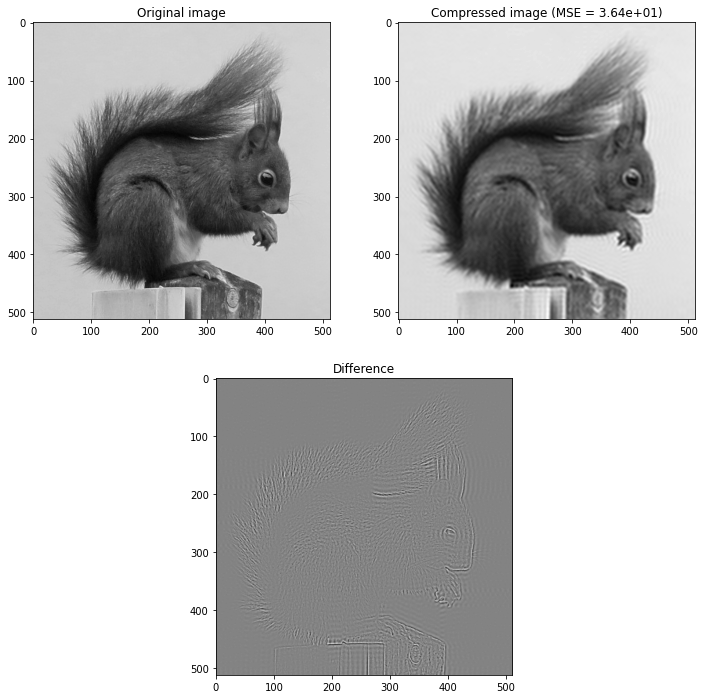

In [23]:
Delta = 255
b = z - x
Pb = np.linalg.norm(b)**2 / (M*N)
PSNR = 10*np.log10(Delta**2/Pb)
EQM =  np.linalg.norm(b)**2 / (M*N)

plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
plt.imshow(x, cmap='gray')
plt.title('Original image')
plt.subplot(2,2,2)
plt.imshow(z, cmap='gray')
plt.title(f'Compressed image (MSE = {EQM:.2e})')
plt.subplot(2,1,2)
plt.imshow(b,cmap='gray')
plt.title('Difference')
plt.show()

The difference image is interesting because we can see that the errors are mainly located in the areas of high frequencies
(contours, tail...).
This makes sense since it is precisely these high frequencies that have been cancelled.

JPEG compression plays on the fact that the human eye is not sensitive to these high-frequency changes.

###  MSE evolution

The previous procedure is now used with different size of the mask,
in order to calculate the MSE between the compressed image and the original image.
The PSNR is also indicated, it is a measure that we will see in a future course.

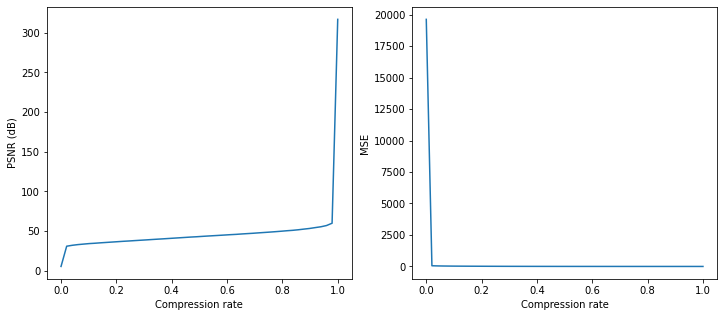

In [24]:
Delta = 255
taux = np.linspace(0,1,50)
EQM = np.zeros(taux.shape)
PSNR = np.zeros(taux.shape)
Px = np.linalg.norm(x)**2 / (M*N)

from numpy import sqrt

for i, t in enumerate(taux):
    
    C = np.sqrt(t*M*N)
    C = int(round(C))
    
    # Compression
    Y = X;
    Mask = np.zeros(Y.shape)
    Mask[:C,:C] = 1
    Z = Y*Mask
    z = fftpack.idctn(Z, norm='ortho')
    
    # Différence entre les deux images
    b = z - x
    
    # EQM
    EQM[i] = np.linalg.norm(b)**2 / (M*N)
    
    # PSNR
    PSNR[i] = 10*np.log10(Delta**2/EQM[i])
    
    # Taux de compression
#     taux[i] = 1-count_nonzero(Mask)/(M*N)

# Affichage
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(taux,PSNR)
plt.xlabel('Compression rate')
plt.ylabel('PSNR (dB)')
plt.subplot(1,2,2)
plt.plot(taux,EQM)
plt.xlabel('Compression rate')
plt.ylabel('MSE')
plt.show()

The analysis of the curves leads to the following conclusions.
* The larger the PSNR, the better the picture quality:
   so it makes sense that it increases as the compression ratio increases.
* Conversely, MSE measures the difference between the compressed image and the original image:
   as the compression ratio increases, the difference becomes smaller and smaller.
* For very large compression ratios, a small variation in the ratio implies a rapid variation in PSNR:
   it drops rapidly. However, their values remain above 80 dB,
   which still corresponds to very good quality.

In classic JPEG compression, the DCT is not directly calculated on the whole image, but on 8 × 8 size thumbnails, as is done below.

### Compression on 8×8 sub-images

The image is divided into blocks of 8×8 pixels, then the DCT is computed on each block,
and finally, the high frequencies of each DCT are cancelled.
To highlight the blocking effect that can appear when the compression is too strong,
the size of the mask is small compared to the size of the sub-images.

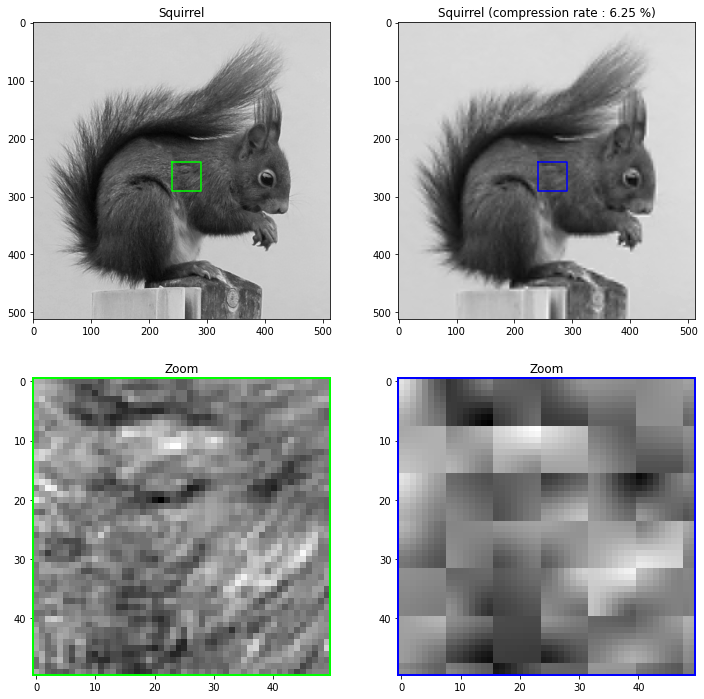

In [25]:
C = 2

B = 8
z = np.zeros(x.shape)

X = fftpack.dctn(x, norm='ortho')

for m in range(M//B):
    for n in range(N//B):
        m1 = m*B
        m2 = (m+1)*B
        n1 = n*B
        n2 = (n+1)*B
        y = x[m1:m2,n1:n2].copy()
        Y = fftpack.dctn(y, norm='ortho')
        b = np.linspace(0, B, B)
        Mask = np.zeros(Y.shape)
        Mask[:C,:C] = 1
        Z = Y*Mask
        z[m1:m2,n1:n2] = fftpack.idctn(Z, norm='ortho')

taux = (C*C) / (B*B)

# Affichage
x1, x2, y1, y2 = 240, 290, 240, 290
plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
plt.imshow(x, cmap='gray')
plt.plot([x1, x1, x2, x2, x1], [y1, y2, y2, y1, y1], color="#00ff00")
plt.title('Squirrel')
plt.subplot(2,2,2)
plt.imshow(z, cmap='gray')
plt.plot([x1, x1, x2, x2, x1], [y1, y2, y2, y1, y1], color="#0000ff")
plt.title('Squirrel (compression rate : {:.2f} %)'.format(taux*100))
ax = plt.subplot(2,2,3)
for pos in ['bottom', 'top', 'left', 'right']:
    ax.spines[pos].set_color('#00ff00')
    ax.spines[pos].set_linewidth(2)
plt.imshow(x[x1:x2,y1:y2], cmap='gray')
plt.title('Zoom')
ax = plt.subplot(2,2,4)
for pos in ['bottom', 'top', 'left', 'right']:
    ax.spines[pos].set_color('#0000ff')
    ax.spines[pos].set_linewidth(2)
plt.imshow(z[x1:x2,y1:y2], cmap='gray')
plt.title('Zoom')
plt.show()